<a href="https://colab.research.google.com/github/omar80-coder/heni/blob/main/RetinaNet_ResNet50_FPN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
BATCH_SIZE = 8
RESIZE_TO = 640
NUM_EPOCHS = 55
#NUM_WORKERS = 4
#DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Définir les classes (par exemple, '__background__', 'stamp', 'signature')
CLASSES = ['__background__', 'stamp', 'signature']
NUM_CLASSES = len(CLASSES)
VISUALIZE_TRANSFORMED_IMAGES = False
OUT_DIR = 'outputs'


In [ ]:
pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import mlflow
# Définir les variables d'environnement pour MLflow
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/akramLh005/PFA-mlflow.mlflow'
os.environ['MLFLOW_TRACKING_USERNAME'] = 'akramLh005'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'fabaf87fce39ef7e9bfdd406d6be4354ce2a25f4'
# Configurez l'URI de suivi pour MLflow
mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])

In [ ]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2


plt.style.use('ggplot')

# This class keeps track of the training and validation loss values
# and helps to get the average for each epoch as well.
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model during training based on the validation mAP.
    """
    def __init__(self, best_valid_map=float('-inf')):
        """
        Initialize the SaveBestModel object with the best validation mAP observed.

        Parameters:
        best_valid_map (float): The best validation mAP observed so far.
        """
        self.best_valid_map = best_valid_map

    def __call__(self, model, current_valid_map, epoch, OUT_DIR):
        """
        If the current validation mAP is higher than the previously observed best, save the model.

        Parameters:
        model (torch.nn.Module): The model to save.
        current_valid_map (float): The current epoch's validation mAP.
        epoch (int): The current epoch number.
        OUT_DIR (str): Directory to save the best model.
        """
        if current_valid_map > self.best_valid_map:
            self.best_valid_map = current_valid_map
            print(f"\nBEST VALIDATION mAP: {self.best_valid_map}")
            print(f"SAVING BEST MODEL AT EPOCH: {epoch+1}\n")
            path = f"{OUT_DIR}/best_model.pth"
            # Sauvegarder le dictionnaire de l'état du modèle
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
            }, path)

            # Enregistrer l'artefact dans MLflow
            #mlflow.log_artifact(path, "best_model")
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))
def create_train_loader(train_dataset, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=0):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True
    )
    return valid_loader

# Define the training tranforms.
import albumentations as A
def get_train_transform():
    return A.Compose([
        A.Rotate(limit=10, p=0.5),
        A.ColorJitter(p=0.4),
        A.MultiplicativeNoise(multiplier=(0.5, 1), per_channel=True, p=0.3),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# Define the validation transforms.
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })


def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR)
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
                cv2.putText(sample, CLASSES[labels[box_num]],
                            (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()


def save_model(epoch, model, optimizerr,scheduler, train_loss_list, validation_loss_list, map_50_list, map_list, OUT_DIR='outputs'):
    """
    Function to save the trained model till the current epoch, or whenever called.
    Additionally, save the training and validation loss and mAP history for continuity in tracking the model's performance.

    Parameters:
    epoch (int): Current epoch number.
    model (torch.nn.Module): Model to be saved.
    optimizer (torch.optim.Optimizer): Optimizer to be saved.
    scheduler (torch.optim.lr_scheduler): Scheduler to be saved.
    train_loss_list (list): List of training loss values.
    validation_loss_list (list): List of validation loss values.
    map_50_list (list): List of mAP@0.50 values.
    map_list (list): List of mean average precision values.
    OUT_DIR (str): Directory to save the model checkpoint.
    """
    path = f'{OUT_DIR}/last_model.pth'  # Define path for clarity and troubleshooting
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),  # Ensure scheduler is passed and saved
        'train_loss_list': train_loss_list,
        'validation_loss_list': validation_loss_list,
        'map_50_list': map_50_list,
        'map_list': map_list,
    }, path)
     #mlflow.log_artifact(path, "model_checkpoints")

    print(f'Model and metrics saved for epoch {epoch}')  # Adjusted to display current epoch



def save_loss_plot(OUT_DIR, train_loss_list, validation_loss_list, x_label='Epochs', y_label='Loss', save_name='loss_plot'):
    """
    Function to save the training and validation loss graphs.

    Parameters:
    OUT_DIR (str): Directory to save the plot.
    train_loss_list (list): List of training loss values.
    validation_loss_list (list): List of validation loss values.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    save_name (str): Filename for the saved plot.
    """
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_list, label='Training Loss', color='blue')
    plt.plot(validation_loss_list, label='Validation Loss', color='red')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"{OUT_DIR}/{save_name}.png")
    plt.close()
    print('SAVING LOSS PLOTS COMPLETE...')

def save_mAP(OUT_DIR, map_05, map):
    """
    Saves the mAP@0.5 and mAP@0.5:0.95 per epoch.
    :param OUT_DIR: Path to save the graphs.
    :param map_05: List containing mAP values at 0.5 IoU (expected as list of tensors or floats).
    :param map: List containing mAP values at 0.5:0.95 IoU (expected as list of tensors or floats).
    """
    if len(map_05) > 0 and isinstance(map_05[0], torch.Tensor):
        map_05 = [m.cpu().item() for m in map_05]  # Appliquer .cpu() à chaque tenseur
    if len(map) > 0 and isinstance(map[0], torch.Tensor):
        map = [m.cpu().item() for m in map]
    # Création du graphique
    figure = plt.figure(figsize=(10, 7), num=1, clear=True)
    ax = figure.add_subplot()
    ax.plot(
        map_05, color='tab:orange', linestyle='-',
        label='mAP@0.5'
    )
    ax.plot(
        map, color='tab:red', linestyle='-',
        label='mAP@0.5:0.95'
    )
    ax.set_xlabel('Epochs')
    ax.set_ylabel('mAP')
    ax.legend()
    plt.title('mAP over Epochs')
    plt.grid(True)
    figure.savefig(f"{OUT_DIR}/map.png")
    plt.close(figure)  # Fermez le graphique pour libérer de la mémoire


In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from PIL import Image
import json
import os
import math
import cv2
from torch.utils.data import Dataset, DataLoader
import numpy as np
class InvoiceDataset(torch.utils.data.Dataset):
    def __init__(self, jsonl_file, image_dir, width, height, classes, transforms=None):
        self.annotations = [json.loads(line) for line in open(jsonl_file, 'r')]
        self.image_dir = image_dir
        self.height = height
        self.width = width
        self.classes = classes
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, idx):
            annotation = self.annotations[idx]
            img_path = os.path.join(self.image_dir, annotation['filename'])
            original_img = Image.open(img_path).convert("RGB")

            # Obtenir les dimensions originales de l'image
            original_width, original_height = original_img.size
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR en RGB
            image = image.astype(np.float32) / 255.0  # Convertir en float32 et normaliser
            image_resized = cv2.resize(image, (self.width, self.height))

            boxes = []
            labels = []
            for key in ['stamp_bbx', 'signature_bbx']:
                box = annotation[key]
                if box is None or (isinstance(box, float) and math.isnan(box)):
                    continue
                box = json.loads(box) if isinstance(box, str) else box

                # Ajuster les coordonnées des boîtes englobantes
                x_min = box[0] * original_width
                y_min = box[1] * original_height
                x_max = x_min + (box[2] * original_width)
                y_max = y_min + (box[3] * original_height)

                xmin_final = (x_min / original_width) * self.width
                xmax_final = (x_max / original_width) * self.width
                ymin_final = (y_min / original_height) * self.height
                ymax_final = (y_max / original_height) * self.height

                # Vérifier que toutes les coordonnées sont à l'intérieur de l'image
                xmin_final = min(max(xmin_final, 0), self.width)
                xmax_final = min(max(xmax_final, 0), self.width)
                ymin_final = min(max(ymin_final, 0), self.height)
                ymax_final = min(max(ymax_final, 0), self.height)

                boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
                # Ajouter les étiquettes associées aux boîtes englobantes
                labels.append(1 if key == 'stamp_bbx' else 2)

            # Convertir les listes de boîtes englobantes en tenseur PyTorch
            boxes = torch.tensor(boxes, dtype=torch.float32)

            # Vérifier le type des étiquettes et les convertir en entiers si nécessaire
            if any(isinstance(label, str) for label in labels):
                labels = [self.classes.index(label) for label in labels]
            labels = torch.tensor(labels, dtype=torch.int64)

            # Créer un dictionnaire contenant les informations sur les boîtes englobantes et les étiquettes
            target = {'boxes': boxes, 'labels': labels}
            if self.transforms:
                sample = self.transforms(image = image_resized,  # Utilisez img ici au lieu de original_img
                                         bboxes = target['boxes'],
                                         labels = labels)
                image_resized = sample['image']  # Mettez à jour img avec l'image transformée
                target['boxes'] = torch.Tensor(sample['bboxes'])

            # Vérifier si les boîtes englobantes sont vides ou nulles
            if np.isnan(target['boxes'].numpy()).any() or target['boxes'].shape == torch.Size([0]):
                target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)


            return image_resized, target

if __name__ == '__main__':
    # Utilisation du dataset avec les transformations d'entraînement
    dataset = InvoiceDataset(
        jsonl_file='/content/drive/MyDrive/requirement samples /Copy of all_data.jsonl',
        image_dir='/content/drive/MyDrive/requirement samples /Copy of 20221109_144858.pdf_1.png',
        # Appliquer la transformation d'entraînement
        width=RESIZE_TO,
        height=RESIZE_TO,
        classes=CLASSES,
        transforms=get_train_transform()
         )

    train_size = int(0.8 * len(dataset))
    valid_size = len(dataset) - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
     #train_dataset.dataset.transforms = get_train_transform()
     #valid_dataset.dataset.transforms = get_valid_transform()
    print(f"Number of training images: {len(dataset)}")
    train_loader = create_train_loader(train_dataset,) # NUM_WORKERS)
    valid_loader = create_valid_loader(valid_dataset,) # NUM_WORKERS)
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(valid_dataset)}\n")


    # Définir la liste des noms de classes (remplacez cette liste par vos propres classes si nécessaire)
    class_names = ['__background__', 'stamp', 'signature']
    # Charger deux échantillons de l'ensemble de données

    import matplotlib.pyplot as plt

    import matplotlib.pyplot as plt

    def visualize_samples(images, targets, class_names):
        for i, (image, target) in enumerate(zip(images, targets)):
            # If the image is a tensor, convert it to a numpy array and rearrange from CHW to HWC
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).cpu().numpy()

            # Convert the image to RGB (not necessary if it's already in RGB)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(8, 8))
            plt.imshow(image)
            for box, label in zip(target['boxes'], target['labels']):
                # Create a Rectangle patch
                rectangle = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                          edgecolor='r', facecolor='none')
                plt.gca().add_patch(rectangle)
                plt.gca().text(box[0], box[1] - 2,
                               f'{class_names[label.item()]}',
                               bbox=dict(facecolor='red', alpha=0.5),
                               fontsize=12, color='white')
            plt.title(f'Sample {i+1}')
            plt.axis('off')
        plt.show()



    sample1_idx = 30
    sample2_idx = 50
    img1, target1 = dataset[sample1_idx]
    img2, target2 = dataset[sample2_idx]

    # Visualiser les échantillons
    visualize_samples([img1, img2], [target1, target2], class_names)


Number of training images: 381
Number of training samples: 304
Number of validation samples: 77



NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/requirement samples /Copy of 20221109_144858.pdf_1.png/20231217_190133_merged-43.pdf_1.png'

In [ ]:
import torchvision
import torch
from functools import partial
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from PIL import Image
import json
import os
import math
import cv2
from torch.utils.data import Dataset, DataLoader
import numpy as np
def create_model(num_classes=91):
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(
        weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1
    )
    num_anchors = model.head.classification_head.num_anchors

    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=256,
        num_anchors=num_anchors,
        num_classes=num_classes,
        norm_layer=partial(torch.nn.GroupNorm, 32)
    )
    return model

if __name__ == '__main__':
    model = create_model(3)
    print(model)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import time
import os
plt.style.use('ggplot')
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(DEVICE)
mlflow.end_run()
def load_checkpoint(model, optimizer, filename='last_model.pth'):
    checkpoint = torch.load(filename, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', float('inf'))
    print(f"Modèle chargé de {filename}, à partir de l'époque {epoch}, avec une perte de {loss}.")
    return model, optimizer, epoch, loss

# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value

# Function for running validation iterations.
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()

    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric.reset()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary
def validate_loss(valid_data_loader, model):
    print('Validating loss')
    model.train()  # Keep the model in training mode
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for data in valid_data_loader:
            images, targets = data
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            count += 1
    return total_loss / count if count > 0 else 0
if __name__ == '__main__':
    os.makedirs('outputs', exist_ok=True)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005 ,nesterov=True)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1, verbose=True)
    mlflow.set_experiment("Retinanet")

    # To monitor training loss
    train_loss_hist = Averager()
    start_epoch, best_loss = 0, float('inf')
    train_loss_list, validation_loss_list, map_50_list, map_list = [], [], [], []
    # Mame to save the trained model with.
    MODEL_NAME = 'model'
    checkpoint_path = 'outputs/last_model.pth'

    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 0) +1 # On commence à l'époque suivante.
        best_loss = checkpoint.get('loss', best_loss)  # Utilisez la perte sauvegardée ou gardez inf si non disponible.

        # Chargement de l'historique des métriques si disponibles.
        train_loss_list = checkpoint.get('train_loss_list', train_loss_list)
        validation_loss_list = checkpoint.get('validation_loss_list', validation_loss_list)
        map_50_list = checkpoint.get('map_50_list', map_50_list)
        map_list = checkpoint.get('map_list', map_list)

        print(f"Modèle chargé de '{checkpoint_path}', à partir de l'époque {start_epoch}, avec une perte de {best_loss}.")

    # Whether to show transformed images from data loader or not.
    if VISUALIZE_TRANSFORMED_IMAGES:
        from custom_utils import show_tranformed_image
        show_tranformed_image(train_loader)
    # To save best model.
    save_best_model = SaveBestModel()

    metric = MeanAveragePrecision()

    # Training loop.
    with mlflow.start_run():
        mlflow.log_params({
            "learning_rate": 0.001,
            "momentum": 0.9,
            "weight_decay": 0.0005,
            "num_classes": NUM_CLASSES,
            "resize_to": RESIZE_TO,
            "num_epochs": NUM_EPOCHS
        })
        for epoch in range(start_epoch, NUM_EPOCHS):
            print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

            # Start timer for the epoch.
            start = time.time()
            # Training phase
            train_loss = train(train_loader, model)
            print(f"Epoch #{epoch+1} train loss: {train_loss:.3f}")
            # Validation phase for loss
            validation_loss = validate_loss(valid_loader, model)
            print(f"Epoch #{epoch+1} validation loss: {validation_loss:.3f}")
            # Validation phase for mAP
            metric_summary = validate(valid_loader, model)
            print(f"Epoch #{epoch+1} mAP: {metric_summary['map']}")

            # End timer for the epoch.
            end = time.time()
            print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

            # Update lists to track history
            train_loss_list.append(train_loss)
            validation_loss_list.append(validation_loss)
            map_50_list.append(metric_summary['map_50'])
            map_list.append(metric_summary['map'])
            # Save the best model
            mlflow.log_metrics({
                        "train_loss": train_loss,
                        "validation_loss": validation_loss,
                        "map_50": metric_summary['map_50'],
                        "map": metric_summary['map'],
                        "epoch_time_minutes": (end - start) / 60
                    }, step=epoch)
            save_best_model(model, float(metric_summary['map']), epoch, 'outputs')

            # Save the model for the current epoch
            save_model(epoch, model, optimizer,scheduler,train_loss_list, validation_loss_list, map_50_list, map_list)

            # Visualize training progress
            save_loss_plot(OUT_DIR, train_loss_list, validation_loss_list)
            save_mAP(OUT_DIR, map_50_list, map_list)
            # Update the learning rate
             #scheduler.step()
        mlflow.end_run()


36,373,375 total parameters.
36,148,031 training parameters.


C:\Users\fnaic\anaconda3\envs\pfa\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Modèle chargé de 'outputs/last_model.pth', à partir de l'époque 50, avec une perte de inf.

EPOCH 51 of 55
Training


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch #51 train loss: 0.226
Validating loss
Epoch #51 validation loss: 0.435
Validating


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch #51 mAP: 0.4319610297679901
Took 15.677 minutes for epoch 51

BEST VALIDATION mAP: 0.4319610297679901
SAVING BEST MODEL AT EPOCH: 51

Model and metrics saved for epoch 50
SAVING LOSS PLOTS COMPLETE...

EPOCH 52 of 55
Training


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch #52 train loss: 0.266
Validating loss
Epoch #52 validation loss: 0.388
Validating


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch #52 mAP: 0.40303897857666016
Took 15.668 minutes for epoch 52
Model and metrics saved for epoch 51
SAVING LOSS PLOTS COMPLETE...

EPOCH 53 of 55
Training


  0%|          | 0/38 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Evaluation function
def validate(valid_data_loader, model):
    model.eval()

    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

if __name__ == '__main__':
    # Load the best model and trained weights.
    model = create_model(num_classes=NUM_CLASSES)
    checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE).eval()
    test_loader = create_valid_loader(valid_dataset)
    metric_summary = validate(test_loader, model)
    print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
    print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

100%|██████████| 9/9 [02:05<00:00, 13.89s/it]

mAP_50: 82.588
mAP_50_95: 44.364


Inference time: 0.309 seconds


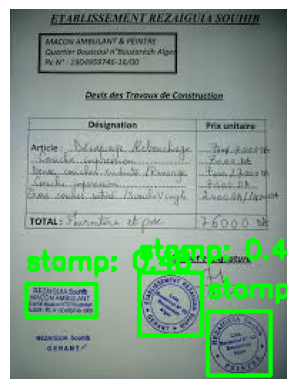

In [ ]:
import numpy as np
import cv2
import torch
import time
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Définir le chemin de l'image et le seuil de détection
#image_path = '../ssd/INV.19.pdf_1.png'
#image_path = '../Downloads/418111381_3808380982754150_2639476541282804670_n.jpg'
image_path = '../Downloads/scan019.jpg'
threshold = 0.3
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
# Charger le modèle
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE).eval()
# Lire et traiter l'image
image = cv2.imread(image_path)
orig_image = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
image_input = torch.tensor(image_input, dtype=torch.float).to(DEVICE)
image_input = torch.unsqueeze(image_input, 0)  # Ajouter une dimension de lot

# Inférence
start_time = time.time()  # Start timing
with torch.no_grad():
    outputs = model(image_input)
end_time = time.time()  # End timing
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.3f} seconds")
# Post-traitement
boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()
labels = outputs[0]['labels'].data.cpu().numpy()

# Filtrer les boîtes selon le seuil
filtered_indices = scores >= threshold
boxes = boxes[filtered_indices].astype(np.int32)
scores = scores[filtered_indices]
pred_classes = [CLASSES[i] for i in labels[filtered_indices]]

# Draw boxes, labels, and scores on the image
for box, class_name, score in zip(boxes, pred_classes, scores):
    color = COLORS[CLASSES.index(class_name)]
    xmin, ymin, xmax, ymax = box
    xmin = int((xmin / image.shape[1]) * orig_image.shape[1])
    ymin = int((ymin / image.shape[0]) * orig_image.shape[0])
    xmax = int((xmax / image.shape[1]) * orig_image.shape[1])
    ymax = int((ymax / image.shape[0]) * orig_image.shape[0])
    cv2.rectangle(orig_image, (xmin, ymin), (xmax, ymax), color, 2)
    label_text = f"{class_name}: {score:.2f}"  # Include score with 2 decimal precision
    cv2.putText(orig_image, label_text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color,2)

# Display the image
plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
import torch
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
def save_indices(train_indices, valid_indices, filepath='dataset_indices.pth'):
    torch.save({
        'train_indices': train_indices,
        'valid_indices': valid_indices
    }, filepath)
    print(f"Indices sauvegardés dans {filepath}.")


In [ ]:
train_indices = train_dataset.indices
valid_indices = valid_dataset.indices
save_indices(train_indices, valid_indices)


Indices sauvegardés dans dataset_indices.pth.


In [ ]:
def load_indices(filepath='dataset_indices.pth'):
    indices = torch.load(filepath)
    return indices['train_indices'], indices['valid_indices']

# Chargement des indices
train_indices, valid_indices = load_indices()

# Recréation des sous-ensembles de données
train_dataset = torch.utils.data.Subset(dataset, train_indices)
valid_dataset = torch.utils.data.Subset(dataset, valid_indices)

# Recréation des DataLoaders
train_loader = create_train_loader(train_dataset)
valid_loader = create_valid_loader(valid_dataset)

In [ ]:
!pip install fvcore

     ---------------------------------------- 0.0/50.2 kB ? eta -:--:--
     --------------- ---------------------- 20.5/50.2 kB 330.3 kB/s eta 0:00:01
     ------------------------------ ------- 41.0/50.2 kB 495.5 kB/s eta 0:00:01
     -------------------------------------- 50.2/50.2 kB 512.5 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/42.2 kB ? eta -:--:--
     ---------------------------------------- 42.2/42.2 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61411 sha256=94aa0898e4edacfff767fe97f78363015f1ddc30113a6ceefeaaeea4f040854e
  Stored in directory: c:\users\fnaic\appdata\local\pip\cache\wheels\b8\79\07\c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for iopath: filename=iop

In [ ]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from fvcore.nn import FlopCountAnalysis, parameter_count_table
input_tensor = torch.randn(1, 3, 640, 640)
input_tensor = input_tensor.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Compute FLOPs
flops = FlopCountAnalysis(model, input_tensor)

# Display the results
print('FLOPs: ', flops.total())
print('Parameter count: ')
print('Parameter count: ')
print(parameter_count_table(model))


C:\Users\fnaic\anaconda3\envs\pfa\lib\site-packages\torch\nn\functional.py:3982: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
C:\Users\fnaic\anaconda3\envs\pfa\lib\site-packages\torchvision\ops\boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
C:\Users\fnaic\anaconda3\envs\pfa\lib\site-packages\torchvision\ops\boxes.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather t

FLOPs:  128321351936
Parameter count: 
Parameter count: 
| name                                   | #elements or shape   |
|:---------------------------------------|:---------------------|
| model                                  | 36.4M                |
|  backbone                              |  31.5M               |
|   backbone.body                        |   23.5M              |
|    backbone.body.conv1                 |    9.4K              |
|    backbone.body.bn1                   |    0.1K              |
|    backbone.body.layer1                |    0.2M              |
|    backbone.body.layer2                |    1.2M              |
|    backbone.body.layer3                |    7.1M              |
|    backbone.body.layer4                |    15.0M             |
|   backbone.fpn                         |   8.0M               |
|    backbone.fpn.inner_blocks           |    0.9M              |
|    backbone.fpn.layer_blocks           |    1.8M              |
|    backbone.fpn.e

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import time
import os
plt.style.use('ggplot')
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(DEVICE)
mlflow.end_run()
def load_checkpoint(model, optimizer, filename='last_model.pth'):
    checkpoint = torch.load(filename, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', float('inf'))
    print(f"Modèle chargé de {filename}, à partir de l'époque {epoch}, avec une perte de {loss}.")
    return model, optimizer, epoch, loss
if __name__ == '__main__':
    os.makedirs('outputs', exist_ok=True)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005 ,nesterov=True)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1, verbose=True)
    train_loss_hist = Averager()
    start_epoch, best_loss = 0, float('inf')
    train_loss_list, validation_loss_list, map_50_list, map_list = [], [], [], []
    # Mame to save the trained model with.
    MODEL_NAME = 'model'
    checkpoint_path = 'outputs/last_model.pth'

    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 0) +1 # On commence à l'époque suivante.
        best_loss = checkpoint.get('loss', best_loss)  # Utilisez la perte sauvegardée ou gardez inf si non disponible.

        # Chargement de l'historique des métriques si disponibles.
        train_loss_list = checkpoint.get('train_loss_list', train_loss_list)
        validation_loss_list = checkpoint.get('validation_loss_list', validation_loss_list)
        map_50_list = checkpoint.get('map_50_list', map_50_list)
        map_list = checkpoint.get('map_list', map_list)

        print(f"Modèle chargé de '{checkpoint_path}', à partir de l'époque {start_epoch}, avec une perte de {best_loss}.")


36,373,375 total parameters.
36,148,031 training parameters.


C:\Users\fnaic\anaconda3\envs\pfa\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Modèle chargé de 'outputs/last_model.pth', à partir de l'époque 52, avec une perte de inf.


In [ ]:
print(map_list)

[tensor(0.0849, device='cuda:0'), tensor(0.0890, device='cuda:0'), tensor(0.1371, device='cuda:0'), tensor(0.2173, device='cuda:0'), tensor(0.2157, device='cuda:0'), tensor(0.2166, device='cuda:0'), tensor(0.2642, device='cuda:0'), tensor(0.2547, device='cuda:0'), tensor(0.2706, device='cuda:0'), tensor(0.2184, device='cuda:0'), tensor(0.3149, device='cuda:0'), tensor(0.3144, device='cuda:0'), tensor(0.3481, device='cuda:0'), tensor(0.3170, device='cuda:0'), tensor(0.3016, device='cuda:0'), tensor(0.3729, device='cuda:0'), tensor(0.3591, device='cuda:0'), tensor(0.3555, device='cuda:0'), tensor(0.3812, device='cuda:0'), tensor(0.3461, device='cuda:0'), tensor(0.3459, device='cuda:0'), tensor(0.3716, device='cuda:0'), tensor(0.3846, device='cuda:0'), tensor(0.3784, device='cuda:0'), tensor(0.3982, device='cuda:0'), tensor(0.3479, device='cuda:0'), tensor(0.3926, device='cuda:0'), tensor(0.3387, device='cuda:0'), tensor(0.3735, device='cuda:0'), tensor(0.4014, device='cuda:0'), tensor(0.